In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

# CNN
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

# others
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import time

# dataset
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import Flowers102

# label
from scipy.io import loadmat
import json
import pycocotools

cudnn.benchmark = True
plt.ion()   # interactive mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Task 1 - Loading Coco Data


In [2]:
from google.colab import drive
#pw: Letmein42
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# from pycocotools.coco import COCO


# # instantiate COCO specifying the annotations json path
# annotations_path = "/content/drive/MyDrive/ki-lab-ss23/data/annotations/instances_val2017.json"

# coco = COCO(annotations_path)
# # Specify a list of category names of interest
# catIds = coco.getCatIds()
# # Get the corresponding image ids and images using loadImgs
# imgIds = coco.getImgIds()
# images = coco.loadImgs(imgIds)

### Visualizing 1 example

In [4]:
from pycocotools.coco import COCO
annotations_path = "/content/drive/MyDrive/ki-lab-ss23/data/annotations/instances_val2017.json"

coco = COCO(annotations_path)
imgIds = coco.getImgIds()


def load_image(imgIdx):
    img_infos = coco.loadImgs(imgIds)
    img_path = "/content/drive/MyDrive/ki-lab-ss23/data/val2017"

    imgInfo = img_infos[imgIdx]

    img_path = f"{img_path}/{imgInfo['file_name']}"
    try:
        return Image.open(img_path)
    except:
        raise Exception()

def pil2tensor(pil_image):
    return torchvision.transforms.PILToTensor()(pil_image).unsqueeze(0) / 255.0

loading annotations into memory...
Done (t=3.14s)
creating index...
index created!


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import random

valid_ids = []
while True:
    i = random.randint(0, len(imgIds))
    try:
        load_image(i)
    except Exception:
        continue

    valid_ids.append(i)
    print(valid_ids)

    if len(valid_ids) > 10:
        break



[4357]
[4357, 2653]
[4357, 2653, 2311]
[4357, 2653, 2311, 818]
[4357, 2653, 2311, 818, 3958]
[4357, 2653, 2311, 818, 3958, 2870]
[4357, 2653, 2311, 818, 3958, 2870, 2870]
[4357, 2653, 2311, 818, 3958, 2870, 2870, 269]
[4357, 2653, 2311, 818, 3958, 2870, 2870, 269, 3006]
[4357, 2653, 2311, 818, 3958, 2870, 2870, 269, 3006, 4385]
[4357, 2653, 2311, 818, 3958, 2870, 2870, 269, 3006, 4385, 1355]


In [7]:
# model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
model_res = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="FasterRCNN_ResNet50_FPN_Weights.DEFAULT")
model_res.to(device)
model_res.eval()

model_mobile = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=torchvision.models.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights)
model_mobile.to(device)
model_mobile.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 90.1MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 85.5MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block):

In [8]:
predictions_res = []
predictions_mobile = []
for i in valid_ids:
    print(i)
    img_as_tensor = pil2tensor(load_image(i)).to(device)
    prediction = model_res(img_as_tensor)
    predictions_res.append(prediction)

    prediction = model_mobile(img_as_tensor)
    predictions_mobile.append(prediction)
    # print(predictions)



4357
2653
2311
818
3958
2870
2870
269
3006
4385
1355


# Filter by score > 0.8

In [9]:
# store bounding boxes with score > 0.8 for each prediction
valid_boxes_res = []
valid_boxes_mobile = []
for prediction in predictions_res:
    valid_boxes_for_this_prediction = []
    for box, label, score in zip(prediction[0]["boxes"], prediction[0]["labels"], prediction[0]["scores"]):
        if score < 0.8:
            continue

        valid_boxes_for_this_prediction.append((box, label, score))
    valid_boxes_res.append(valid_boxes_for_this_prediction)


for prediction in predictions_mobile:
    valid_boxes_for_this_prediction = []
    for box, label, score in zip(prediction[0]["boxes"], prediction[0]["labels"], prediction[0]["scores"]):
        if score < 0.8:
            continue

        valid_boxes_for_this_prediction.append((box, label, score))
    valid_boxes_mobile.append(valid_boxes_for_this_prediction)

# Visualize results

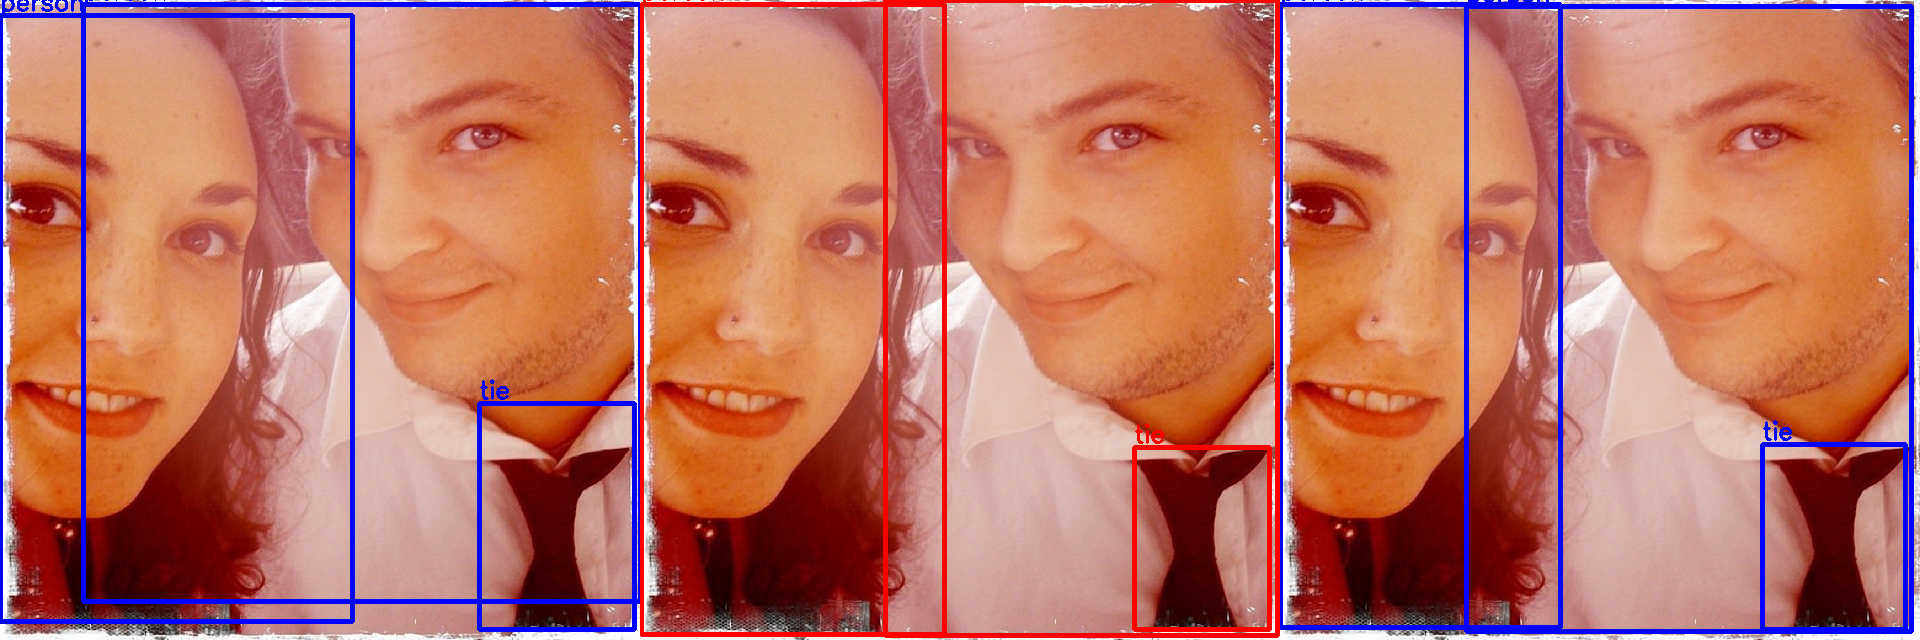

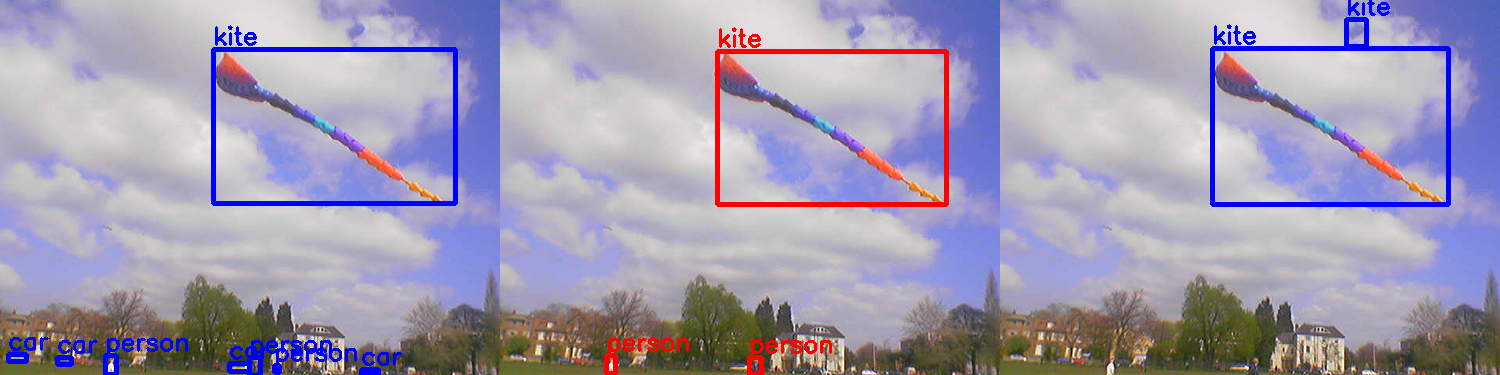

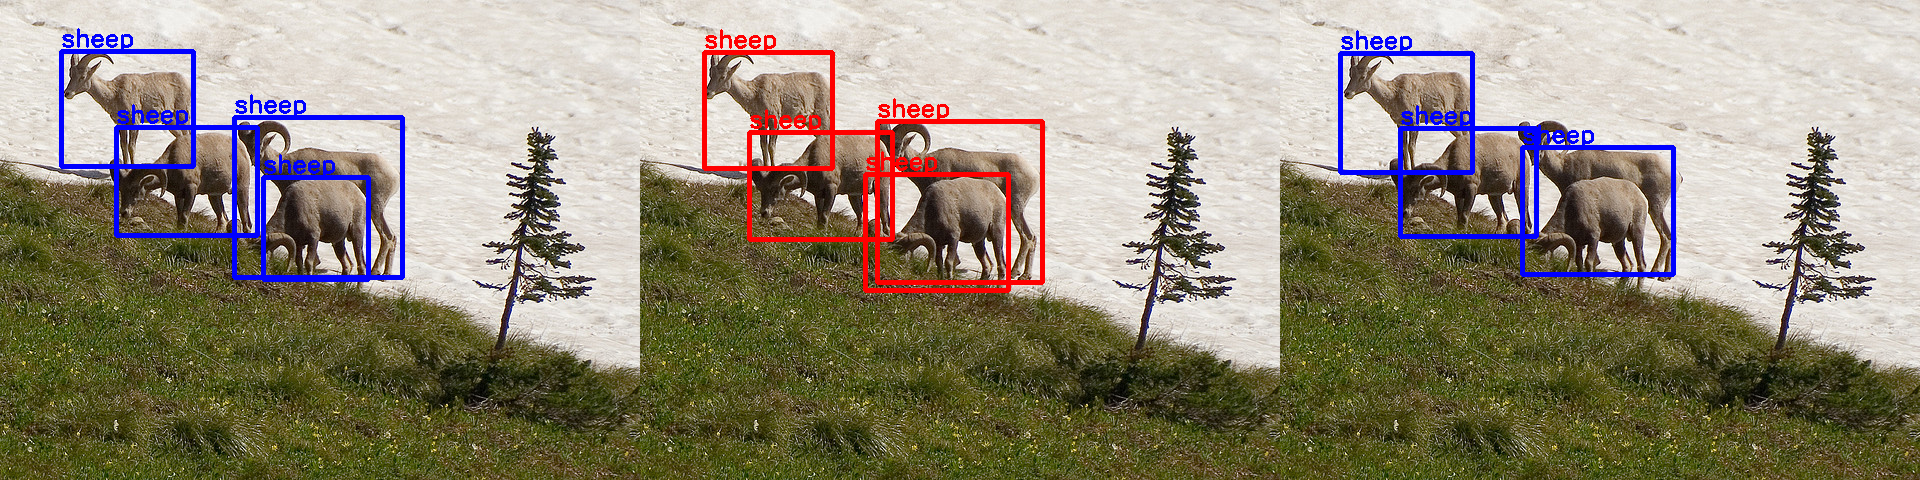

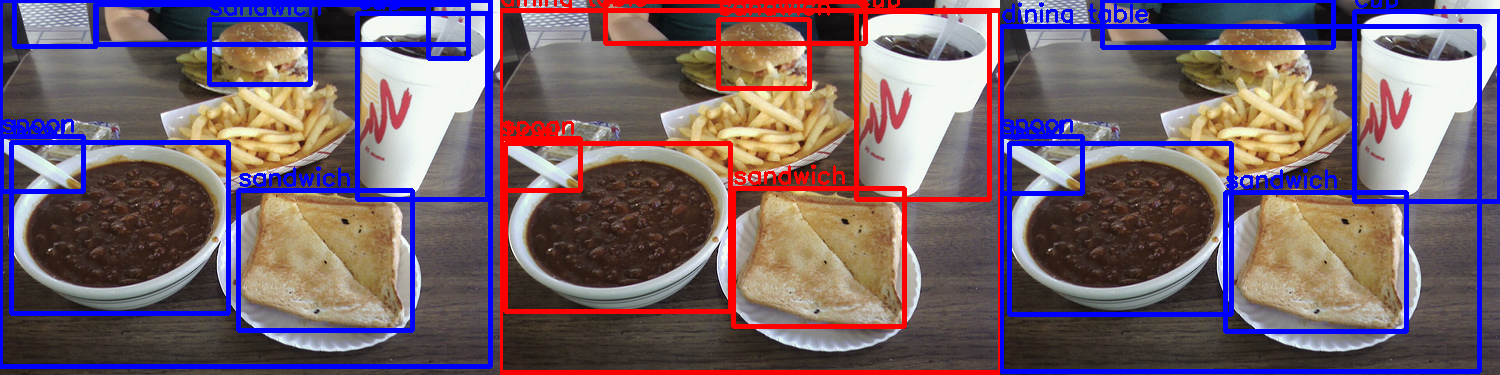

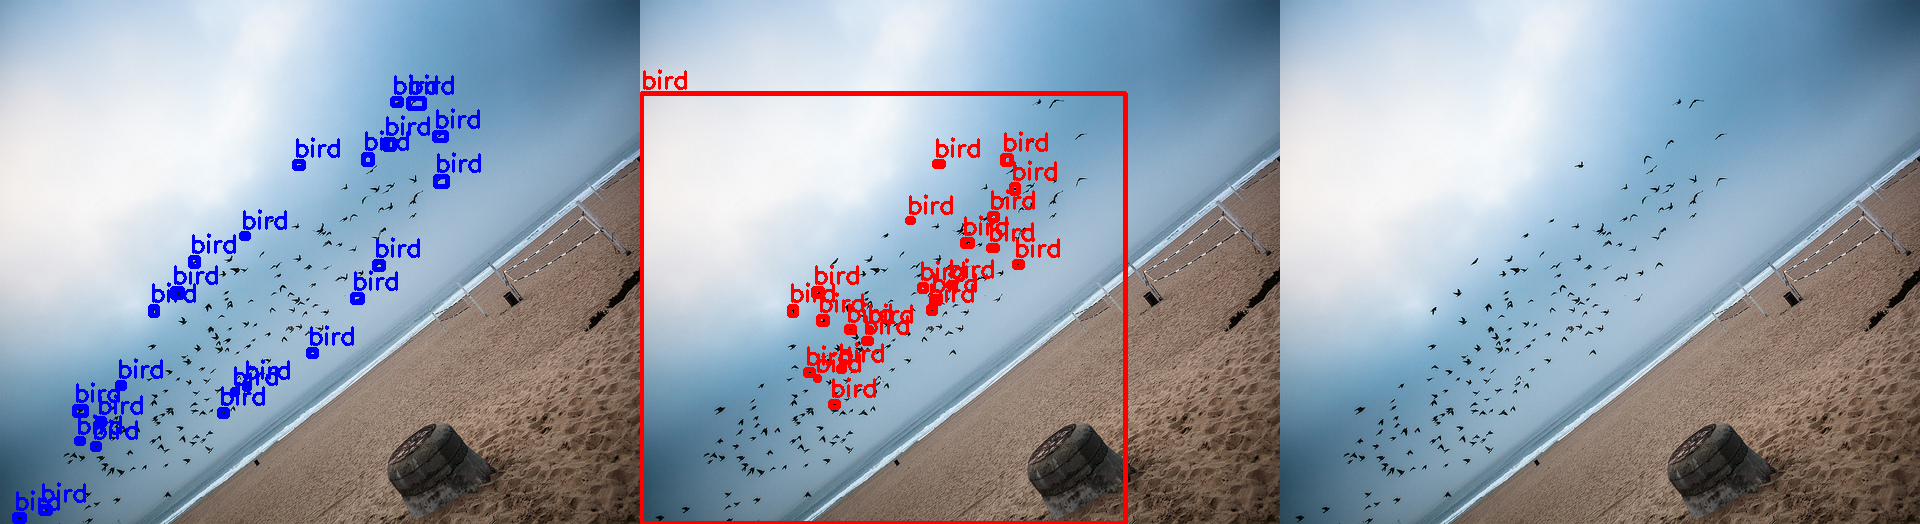

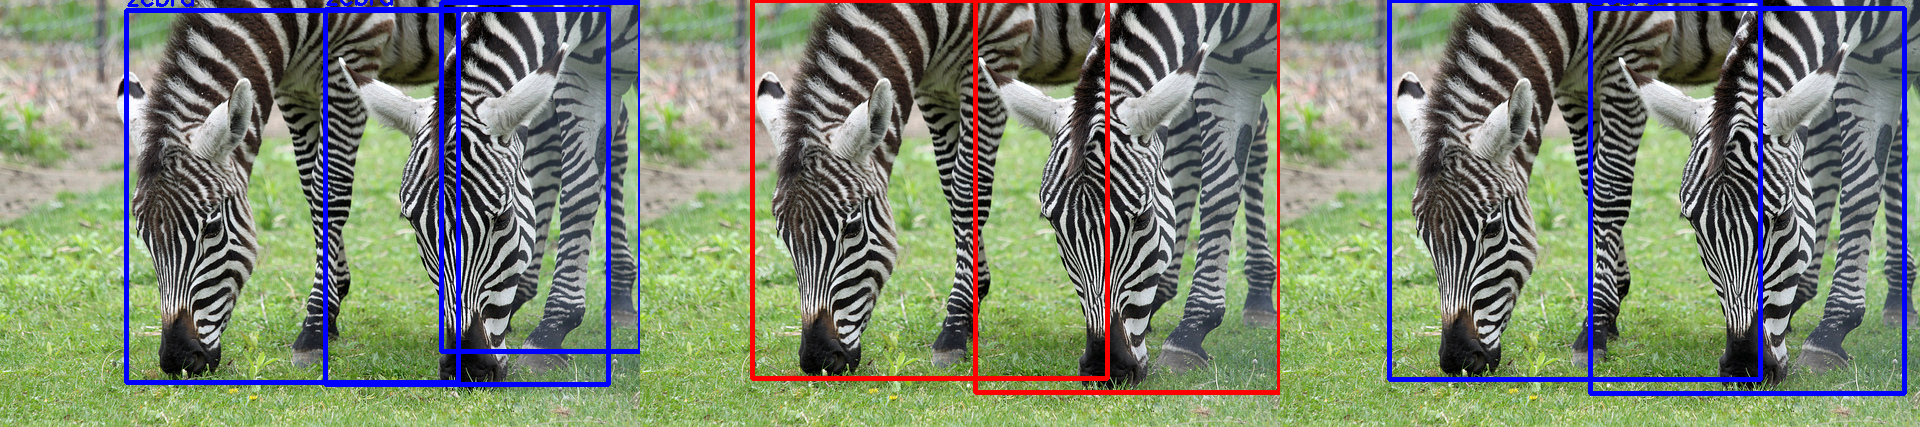

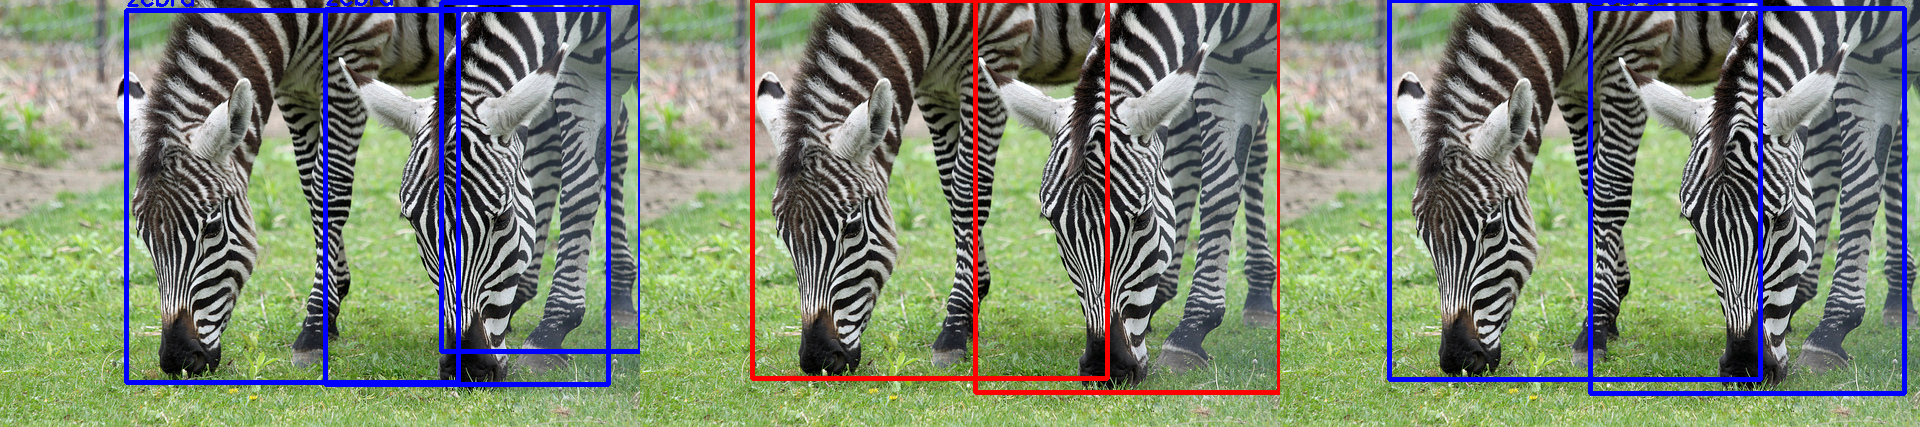

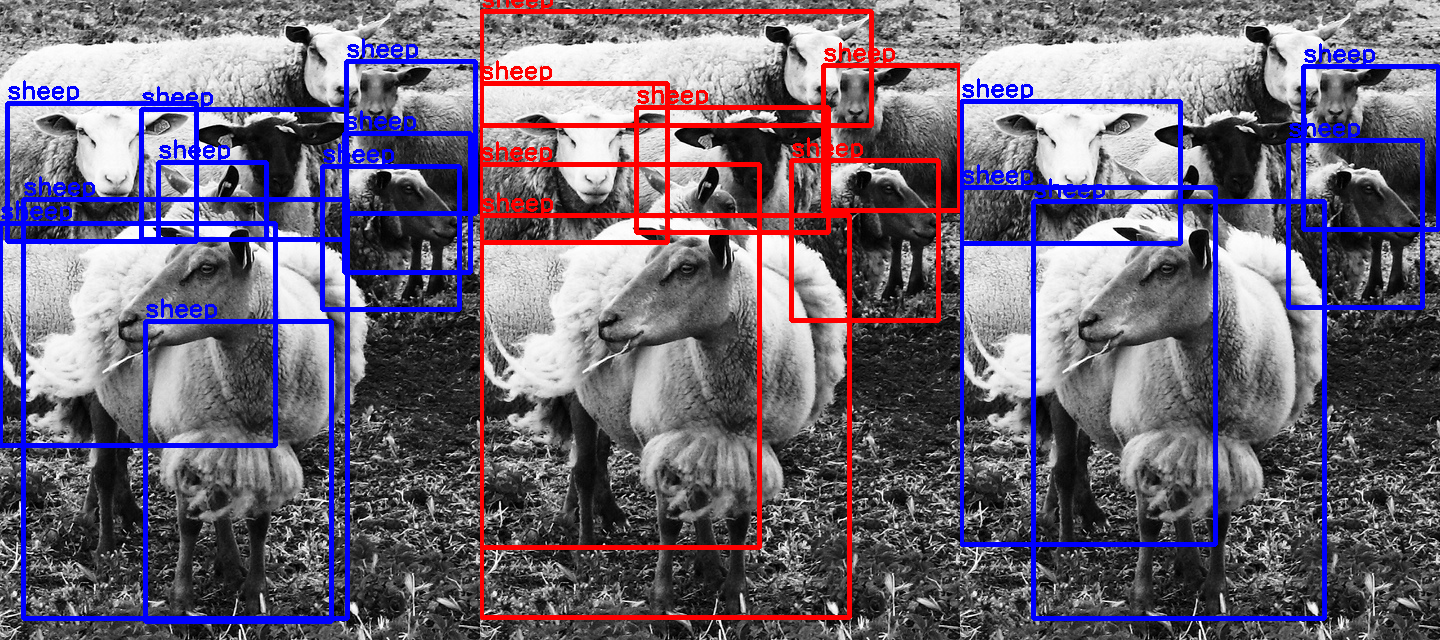

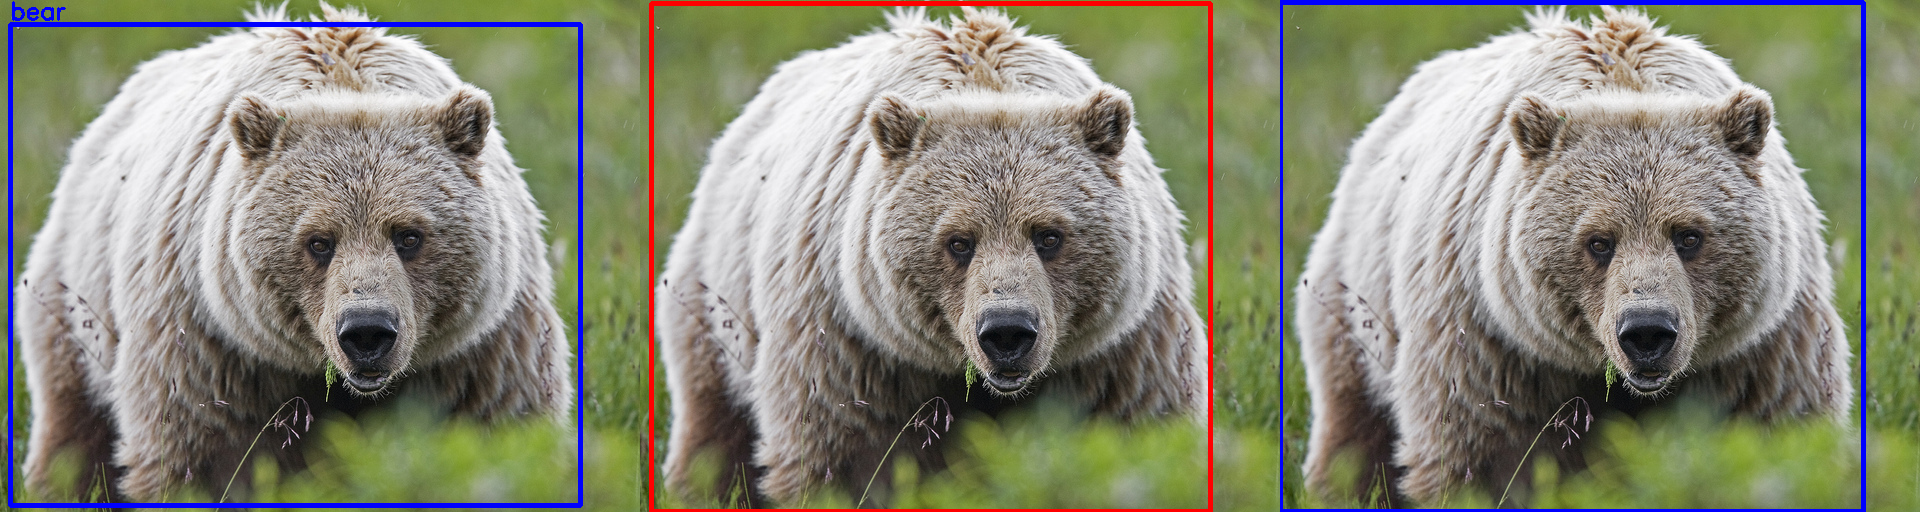

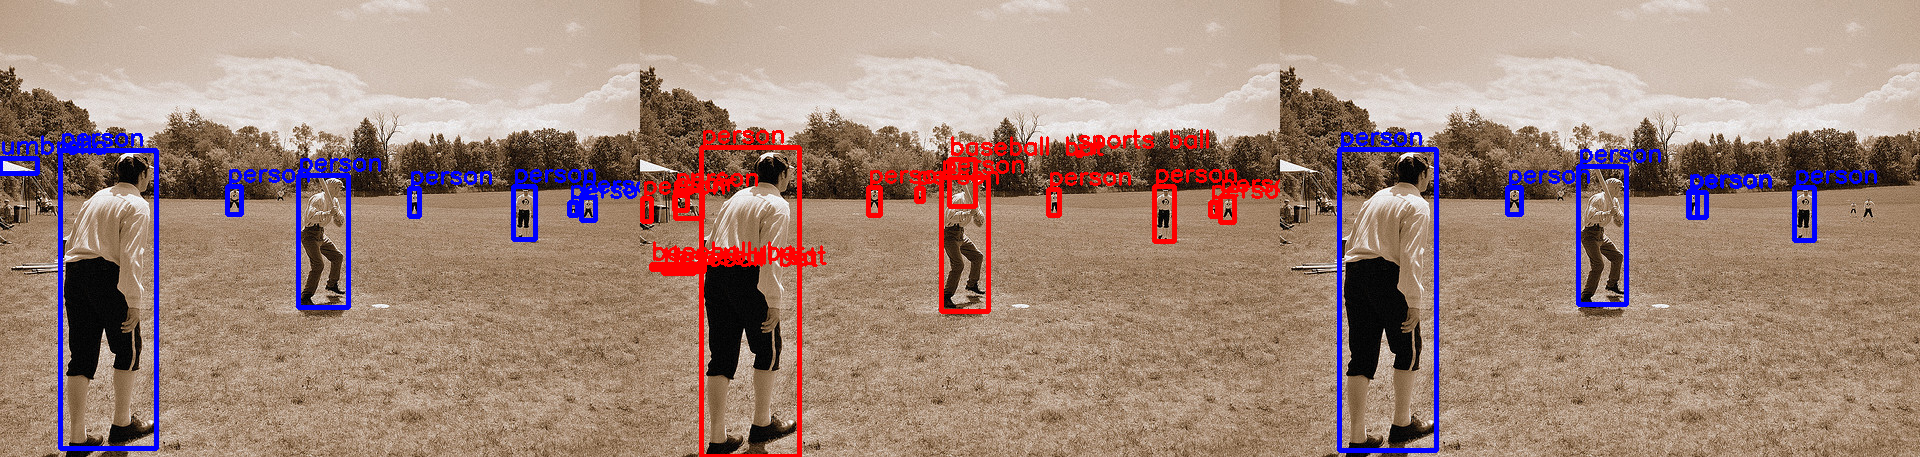

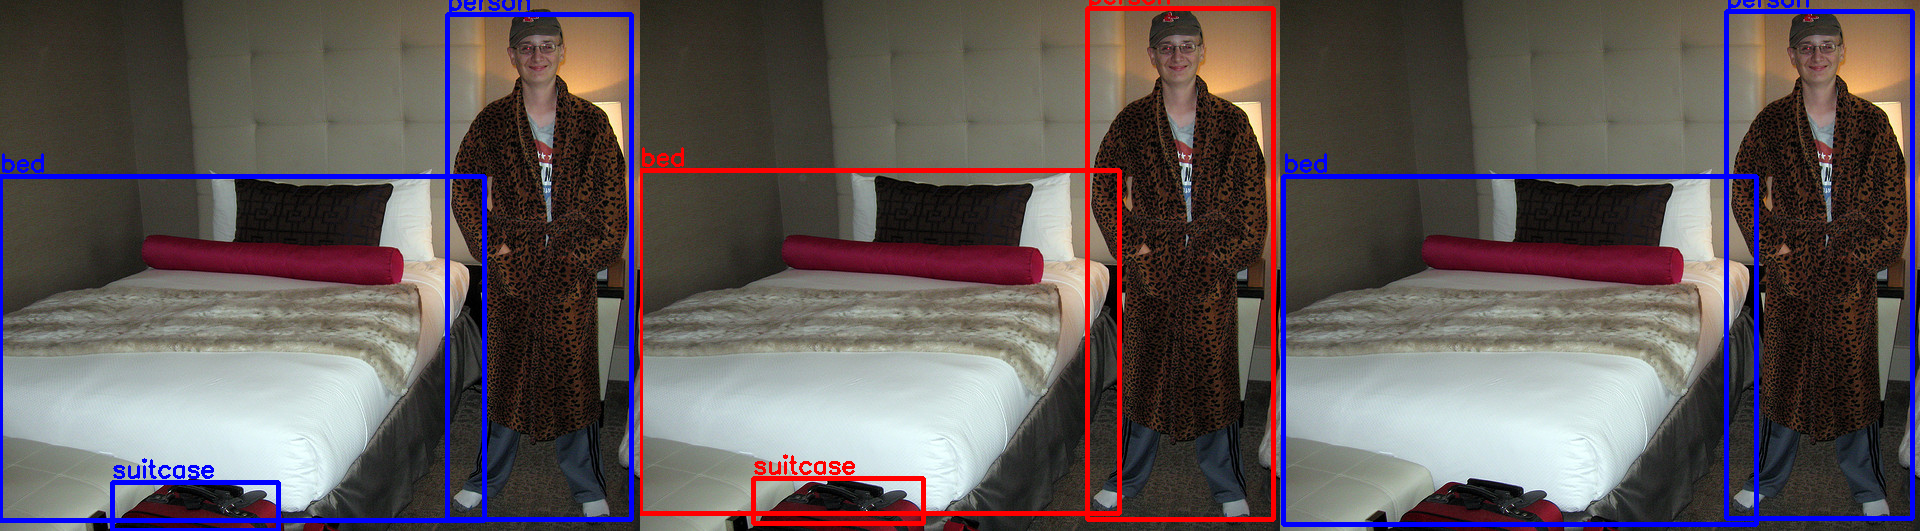

In [10]:
from google.colab.patches import cv2_imshow
import cv2

for id, bboxes_raw_res, bboxes_raw_mobile in zip(valid_ids, valid_boxes_res, valid_boxes_mobile):
    pil_image = load_image(id)

    imgIds = coco.getImgIds()
    img_infos = coco.loadImgs(imgIds)
    imgInfo = img_infos[id]
    annIds = coco.getAnnIds(imgIds=imgInfo['id'])
    anns = coco.loadAnns(annIds)

    img_id = img_infos[id]["id"]


    color = (0, 0, 255)
    thickness = 3
    # Convert RGB to BGR

    open_cv_image = np.array(pil_image)
    open_cv_image_pred_res = open_cv_image[:, :, ::-1].copy()
    open_cv_image_pred_mobile = open_cv_image[:, :, ::-1].copy()
    open_cv_image_truth = open_cv_image[:, :, ::-1].copy()

    for ann in anns:
        bbox = np.array(ann["bbox"]).astype("int")
        label_as_int = ann["category_id"]
        label = coco.loadCats(label_as_int)[0]["name"]

        cv2.rectangle(open_cv_image_truth, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), color, thickness)

        center = (bbox[2] - bbox[0], bbox[3] - bbox[1])
        cv2.putText(open_cv_image_truth, label, (bbox[0], bbox[1] - 5), fontFace=0, fontScale=0.8, color=color, thickness=2)


    color = (255, 0, 0)
    for bbox_raw in bboxes_raw_res:
        bbox = bbox_raw[0].cpu().detach().numpy().astype(int)
        label_as_int = bbox_raw[1].item()
        label = coco.loadCats(label_as_int)[0]["name"]

        cv2.rectangle(open_cv_image_pred_res, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)

        center = (bbox[2] - bbox[0], bbox[3] - bbox[1])
        cv2.putText(open_cv_image_pred_res, label, (bbox[0], bbox[1] - 5), fontFace=0, fontScale=0.8, color=color, thickness=2)


    color = (255, 0, 0)
    for bbox_raw in bboxes_raw_mobile:
        bbox = bbox_raw[0].cpu().detach().numpy().astype(int)
        label_as_int = bbox_raw[1].item()
        label = coco.loadCats(label_as_int)[0]["name"]

        cv2.rectangle(open_cv_image_pred_mobile, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, thickness)

        center = (bbox[2] - bbox[0], bbox[3] - bbox[1])
        cv2.putText(open_cv_image_pred_mobile, label, (bbox[0], bbox[1] - 5), fontFace=0, fontScale=0.8, color=color, thickness=2)


    combined_image = cv2.hconcat([open_cv_image_pred_res, open_cv_image_truth, open_cv_image_pred_mobile])
    cv2_imshow(combined_image)

## IoU

In [13]:
iou_res = []
iou_mobile = []
#looping over images
for id, bboxes_raw_res, bboxes_raw_mobile in zip(valid_ids, valid_boxes_res, valid_boxes_mobile):
    imgIds = coco.getImgIds()
    img_infos = coco.loadImgs(imgIds)
    imgInfo = img_infos[id]
    annIds = coco.getAnnIds(imgIds=imgInfo['id'])
    anns = coco.loadAnns(annIds)
    img_id = img_infos[id]["id"]

    # only bboxes_raw_res[i][0] and anns[i]["bbox"] are actual bbox
    anns = ([[entry["bbox"][0], entry["bbox"][1], entry["bbox"][0]+entry["bbox"][2], entry["bbox"][1]+entry["bbox"][3]] for entry in anns])

    # ignore cases where no bounding boxes were detected
    if len(anns) == 0 or len(bboxes_raw_res) == 0 or len(bboxes_raw_mobile) == 0:
        continue


    bbox_tlist_anns = torch.tensor([entry for entry in anns]).to(device)
    bbox_list_res = [entry[0] for entry in bboxes_raw_res]
    bbox_tlist_res = torch.stack(bbox_list_res).to(device)
    bbox_list_mobile = [entry[0] for entry in bboxes_raw_mobile]
    bbox_tlist_mobile = torch.stack(bbox_list_mobile).to(device)
    #print(torchvision.ops.box_iou(bbox_tlist_anns, bbox_tlist_anns))
    iou_res.append(torchvision.ops.box_iou(bbox_tlist_res, bbox_tlist_anns))
    iou_mobile.append(torchvision.ops.box_iou(bbox_tlist_mobile, bbox_tlist_anns))


In [14]:
#print(iou_res)
print('res iou: ', np.mean([t.cpu().detach().numpy().max() for t in iou_res]))
print('mobile iou: ', np.mean([t.cpu().detach().numpy().max() for t in iou_mobile]))

res iou:  0.9192588
mobile iou:  0.93962944
